## Imports and setup

In [1]:
from MatlabFuncs import *
from model import *
from triangle import *
from bamg import bamg
from savevars import *
import plotdoc
from loadmodel import *
import os
from os.path import exists

from export_netCDF import export_netCDF

from scipy.io import loadmat
from m1qn3inversion import *
import numpy as np
from ContourToNodes import *
from solve import *

#import lhsmdu #install in terminal 'pip install lhsmdu'
import matplotlib.pyplot as plt
import pickle

import numpy as np
from osgeo import gdal
from matplotlib import pyplot as plt

from InterpFromGridToMesh import InterpFromGridToMesh
from InterpFromMeshToMesh2d import InterpFromMeshToMesh2d

import copy
import utilities
from reinitializelevelset import *

## Time travel back to 1985

In [2]:
# Load the _Param model
md = loadmodel('/efs/GrIS_Outlet_Glacier_Seasonal_dhdt/Models/SAtoES_Param.nc')


Opening /efs/GrIS_Outlet_Glacier_Seasonal_dhdt/Models/SAtoES_Param.nc for reading 
group toolkits is empty
group results is empty


### [1] Shift the surface to the 1985 DEM

#### Analysis

Fit a line to the 1985 surface elevations [versus] the present-day surface elevations, for points that lie between 700 m and 1000 m. Because we're using the 1985 DEM near the margin and filling in the empty nodes with the shifted present-day surface further into the interior, we want to find the shift at these higher elevations, rather than use the differences from lower elevations, close to the margin.

y =  0.98x + 50.59


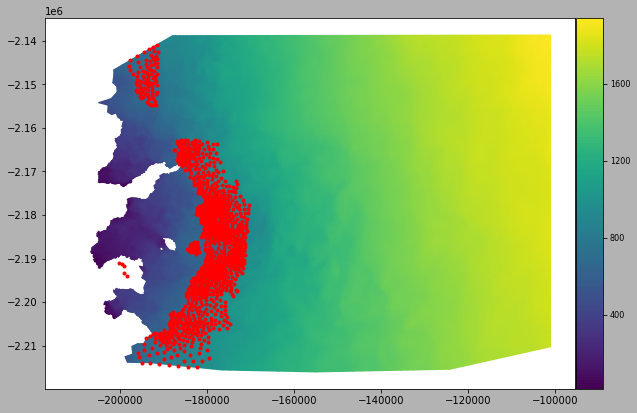

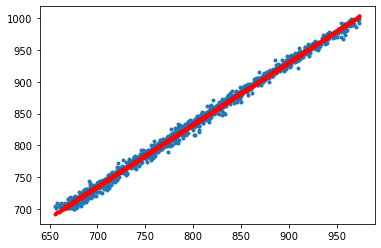

RMS of residuals =   5.6 m


In [3]:
# Interpolate the 1985 DEM surface elevations
z_1985dem = utilities.interp1985DEM(md.mesh.x, md.mesh.y)

# Select the points that will be used to create the linear relationship between the two surfaces
pos = (~np.isnan(z_1985dem - md.geometry.surface)) & (z_1985dem > 700) & (z_1985dem < 1000)

fig = plt.figure(figsize=(10,10))
plotmodel(md, 'data', md.geometry.surface, 'mask', md.mask.ice_levelset<0)
plt.plot(md.mesh.x[pos], md.mesh.y[pos], 'r.')

# Find the linear relationship
p = np.polyfit(md.geometry.surface[pos], z_1985dem[pos], 1)

fig = plt.figure()
plt.plot(md.geometry.surface[pos], z_1985dem[pos], '.')
print('y = {:5.2f}x + {:5.2f}'.format(p[0], p[1]))

z_polyval = np.polyval(p, md.geometry.surface[pos])
plt.plot(md.geometry.surface[pos], z_polyval, 'r.')
plt.show()
residuals = z_1985dem[pos] - z_polyval
print('RMS of residuals = {:5.1f} m'.format(np.sqrt(np.mean(residuals**2))))


It looks like we have a good linear fit, with an RMS of residuals of about 5.6 m. The intercept of the linear fit is about 50 m, indicating that the 1985 surface is about 50 m higher than the present-day surface at the red points on the map above. The slope of the linear fit is ~1, indicating that this 50 m shift is applicable at all of these red dots, with an error of about 5.6 m (RMS of residuals).

#### Code to use for the ensemble setup

In [4]:
# Interpolate the 1985 DEM surface elevations
z_1985dem = utilities.interp1985DEM(md.mesh.x, md.mesh.y)

# Shift the surface
surf_shifted = utilities.surface_shift(md, md.geometry.surface, z_1985dem)
md.geometry.surface = surf_shifted


### [2] Extend the ice mask to the 1985 terminus positions

Find points where bed < 0 m and surface > 42 m. This threshold of 42 m puts us sufficiently above the geoid (mean sea surface) to get the glacial ice and not pick up any icebergs.

In [5]:
# Find the points where bed < 0 and the new surface > 42 m
ice_levelset_original = copy.deepcopy(md.mask.ice_levelset)
pos = (md.geometry.bed < 0) & (md.geometry.surface > 42) & (md.mask.ice_levelset > 0) & (md.mesh.vertexonboundary == 0)

# Fill in these points with ice
md.mask.ice_levelset[pos] = -1
md.mask.ice_levelset = reinitializelevelset(md, md.mask.ice_levelset)


#### Analysis

Check visually the locations to which we've extrapolated the ice mask.

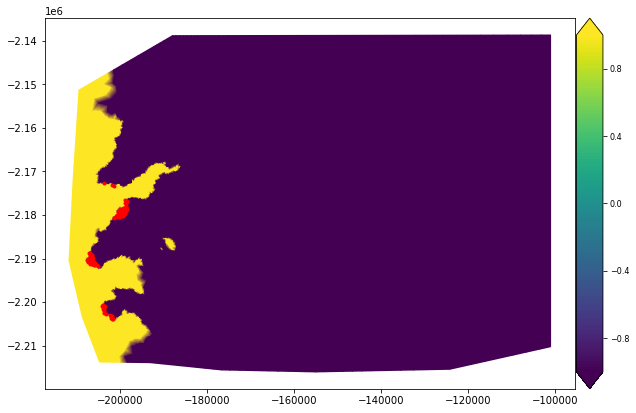

In [6]:
fig = plt.figure(figsize=(10,10))
plotmodel(md, 'data', md.mask.ice_levelset, 'caxis', [-1, +1], 'backgroundcolor', 'white')
plt.plot(md.mesh.x[pos], md.mesh.y[pos], 'r.')


### [3] Extrapolate the friction coefficient 

In [7]:
from scipy.interpolate import griddata

valid = (ice_levelset_original < 0) & (md.geometry.surface < 300)
extrap = (md.geometry.bed < 0) & (md.geometry.surface > 42) & (ice_levelset_original > 0) & (md.mesh.vertexonboundary == 0)

friction_coefficient_extrap = griddata((md.mesh.x[valid], md.mesh.y[valid]), \
                                        md.friction.coefficient[valid], \
                                       (md.mesh.x[extrap], md.mesh.y[extrap]), \
                                        method='nearest')

md.friction.coefficient[extrap] = friction_coefficient_extrap


#### Analysis

Inspect the nearest neighbor extrapolation visually (qualitatively).

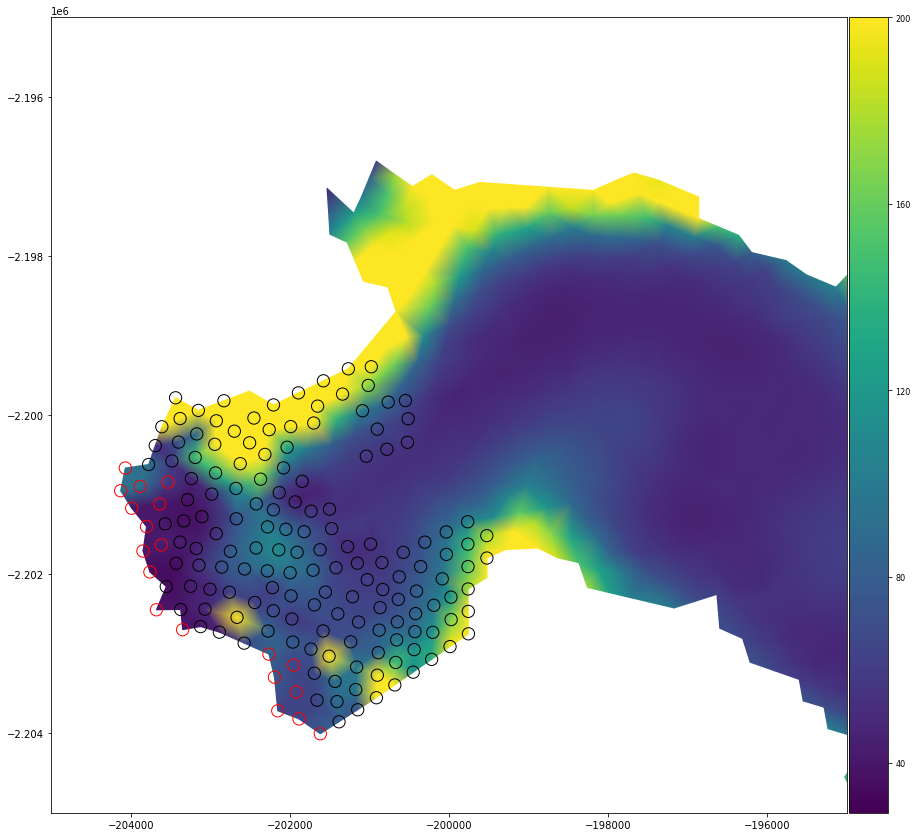

In [8]:
fig = plt.figure(figsize=(15,15))
plotmodel(md, 'data', md.friction.coefficient, 'mask', md.mask.ice_levelset < 0, 'backgroundcolor', 'white')
plt.scatter(md.mesh.x[valid], md.mesh.y[valid], s=150., facecolors='none', edgecolors='k')
plt.scatter(md.mesh.x[pos], md.mesh.y[pos], s=150., facecolors='none', edgecolors='r')

glacier_zoom = 'EQI'

if glacier_zoom == 'AVA':
    plt.xlim(-210000, -195000)
    plt.ylim(-2180000, -2165000)

if glacier_zoom == 'KUJ':
    plt.xlim(-205000, -195000)
    plt.ylim(-2183000, -2175000)

if glacier_zoom == 'KAN':
    plt.xlim(-210000, -200000)
    plt.ylim(-2193000, -2185000)

if glacier_zoom == 'EQI':
    plt.xlim(-205000, -195000)
    plt.ylim(-2205000, -2195000)

if glacier_zoom == 'SAtoES':
    plt.xlim(-220000, -180000)
    plt.ylim(-2210000, -2160000)
        